# COVID-19 Policy Analysis

## Import required modules

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.patches as patches
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pandas.plotting import register_matplotlib_converters
from numpy.polynomial.polynomial import polyfit
register_matplotlib_converters()
pd.options.mode.chained_assignment = None # default='warn'

## Load data

In [2]:
# Read in the data
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

demo_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv", 
                       keep_default_na=False, na_values=[""])

xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")
fc_data = pd.read_excel(xls, 'h6_facial_coverings')

## List of country and state codes

In [28]:
# second code required for face covering policy data

country_code = [
['US','USA'],
['CA','CAN'],
['AU','AUS'],
['NZ','NZL'],
['SN','SEN'],
['IL','ISR'],
['EG','EGY'],
['CN','CHN'],
['TH','THA'],
['SG','SGP'],
['PH','PHL'],
['RU','RUS'],
# ['BR','BRA'],
['AT','AUT'],
['BE','BEL'],
['CZ','CZE'],
['DK','DNK'],
['FI','FIN'],
['FR','FRA'],
['GB','GBR'],
['DE','DEU'],
['IE','IRL'],
['IT','ITA'],
['NL','NLD'],
['PO','POL'],
['PT','PRT'],
['ES','ESP'],
['SE','SWE'],
['NO','NOR'],
['CH','CHE'],
['IS','ISL'],
['TR','TUR'],
['HK','HKG'],
['IN','IND'],
['JP','JPN'],
['KR','KOR'],
['TW','TWN'],
['VN','VNM']]

state_code = [
['US_AK','USA'],
['US_AL','USA'],
['US_AR','USA'],
['US_AZ','USA'],
['US_CA','USA'],
['US_CO','USA'],
['US_CT','USA'],
['US_DC','USA'],
['US_DE','USA'],
['US_FL','USA'],
['US_GA','USA'],
['US_HI','USA'],
['US_IA','USA'],
['US_ID','USA'],
['US_IL','USA'],
['US_IN','USA'],
['US_KS','USA'],
['US_KY','USA'],
['US_LA','USA'],
['US_MA','USA'],
['US_MD','USA'],
['US_ME','USA'],
['US_MI','USA'],
['US_MN','USA'],
['US_MO','USA'],
['US_MS','USA'],
['US_MT','USA'],
['US_NC','USA'],
['US_ND','USA'],
['US_NE','USA'],
['US_NH','USA'],
['US_NJ','USA'],
['US_NM','USA'],
['US_NV','USA'],
['US_NY','USA'],
['US_OH','USA'],
['US_OK','USA'],
['US_OR','USA'],
['US_PA','USA'],
['US_RI','USA'],
['US_SC','USA'],
['US_SD','USA'],
['US_TN','USA'],
['US_TX','USA'],
['US_UT','USA'],
['US_VA','USA'],
['US_VT','USA'],
['US_WA','USA'],
['US_WI','USA'],
['US_WV','USA'],
['US_WY','USA']]

## Process data for regions listed above

In [8]:
# Country Codes 
# 1. New Zealand       NZ
# 2. Australia         AU
# 3. Singapore         SG  
# 4. Thailand          TH
# 5. Somalia           SO

# YELLOW
# 1. China             CN   
# 2. Egypt             EG
# 3. Israel            IL
# 4. Kyrgyzstan        KG
# 5. Tajikistan        TJ

# RED
# 1. USA               US
# 2. Brazil            BR
# 3. Canada            CA
# 4. Philippines       PH
# 5. Russia            RU

start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

def preprocess_fc_data(data):
    data.columns = ['face_covering']
    data.index.name = 'date'
    data.index = pd.to_datetime(data.index)
    return data

def preprocess_data(epi_data, gr_data, fc_data, demo_data, code1, code2):
    epi_df = epi_data[(epi_data.key) == code1]
    epi_df['rolling_cases'] = epi_df['new_confirmed'].rolling(7).mean()
    gr_df = gr_data[(gr_data.key) == code1]
    fc_df = fc_data[(fc_data.country_code) == code2].drop(columns=['country_code', 'country_name']).T
    try:
        fc_df = preprocess_fc_data(fc_df)
    except:
        print(code1)
    demo_df = demo_data[(demo_data.key == code1)]
    return epi_df, gr_df, fc_df, demo_df
    
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    cc2 = state_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)
    
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    cc2 = country_code[i][1]
    globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], globals()["{0}_fc_df".format(cc1)], \
    globals()["{0}_demo_df".format(cc1)] = preprocess_data(epi_data, gr_data, fc_data, demo_data, cc1, cc2)

# epidemiology data consists of the following columns
# date, key, new_confirmed, new_deceased, new_recovered, new_tested, total_confirmed, total_deceased,
# total_recovered, total_tested

# government response data consists of many columns. Can see them here
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies

## Plotting functions

In [9]:
def plot_health_policies(epi_data, gr_data, fc_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Health Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')
    
    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['testing_policy']/3,
            color='red',
            label='testing')

    ax2.plot(gr_data.index.values,
            gr_data['contact_tracing']/2,
            color='orange',
            label='contact tracing')
    
    ax2.plot(fc_data.index.values,
            fc_data['face_covering']/4,
            color='purple',
            label='face covering')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    
def plot_containment_policies(epi_data, gr_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Containment Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')

    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['restrictions_on_gatherings']/4,
            color='red',
            label='gathering restrictions')

    ax2.plot(gr_data.index.values,
            gr_data['workplace_closing']/3,
            color='orange',
            label='workplace closures')

    ax2.plot(gr_data.index.values,
            gr_data['school_closing']/3,
            color='purple',
            label='school closures')

    ax2.plot(gr_data.index.values,
            gr_data['stay_at_home_requirements']/3,
            color='yellow',
            label='stay at home orders')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()

In [10]:
def calculate_average_index(epi_data, gr_data, demo_data, country):
    C1 = gr_data['school_closing']/3
    #display(max(C1))
    C2 = gr_data['workplace_closing']/3
    #display(max(C2))
    C3 = gr_data['cancel_public_events']/2
    #display(max(C3))
    C4 = gr_data['restrictions_on_gatherings']/4
    #display(max(C4))
    C5 = gr_data['public_transport_closing']/2
    #display(max(C5))
    C6 = gr_data['stay_at_home_requirements']/3
    #display(max(C6))
    C7 = gr_data['restrictions_on_internal_movement']/2
    #display(max(C7))
    C8 = gr_data['international_travel_controls']/4
    #display(max(C8))
    gr_data['contain_policy_avg'] = ((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8) / 8 ) * 100
    gr_data['containment_idx'] = gr_data['contain_policy_avg'].sum()/len(gr_data)
#     print(country, 'containment index: ', gr_data['containment_idx'].values[0])
    gr_data['si_average'] = gr_data['stringency_index'].sum()/len(gr_data)
#     print(country, 'stringency index: ', gr_data['si_average'].values[0])
    return pd.to_numeric(gr_data['si_average'].values[0])   
    
def plot_state_by_index(epi_data, demo_data, country, ax0, ax, i, state_list):
    start_remove = ('2019-12-30')
    end_remove = ('2020-2-29')
    epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    p = ax0.fill_between(epi_data.index.values, case_rate_100K)
    path = p.get_paths()[0]
    pp = patches.PathPatch(path, alpha=0.15)
    ax.add_patch(pp)
    art3d.pathpatch_2d_to_3d(pp,z=i,zdir='y')
    ax.set_xlim3d([dt.date(2020, 3, 1), dt.date(2020, 12, 1)])
    ax.set_ylim3d(0, i)
    ax.set_zlim3d(0, 200)
    ax.grid(False)
    months = {"Jan":0, "Feb":1, "Mar":2, "Apr":3, "May":4, "Jun":5, "Jul":6, 
              "Aug":7, "Sep":8, "Oct":9, "Nov":10, "Dec":11 }
    month_idx = np.unique(epi_data.index.month_name()).tolist()
    month_idx = [month[0:3] for month in month_idx]
    month_idx = sorted(month_idx, key=months.get)
    ax.set_xticklabels(month_idx, fontsize=8)
    ax.yaxis._axinfo['juggled'] = (1,1,0)
    ax.set_yticks(np.arange(1,len(state_list)+1))
    ax.set_yticklabels(state_list, 
                verticalalignment='baseline',
                horizontalalignment='right',
                fontsize=8)
    ax.set_zticks([])
    ax.w_zaxis.line.set_lw(0.)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    return

def plot_stringency_index(epi_data, gr_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Cases')
    ax.set_ylim([0, 25])
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')

    ax2 = ax.twinx()
    ax2.set_ylim([0, 100])
    ax2.set(ylabel='Stringency Index')
    ax2.plot(gr_data.index.values,
            gr_data['stringency_index'],
            color='green',
            label='stringency index')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    return

## US cases per capita by state

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


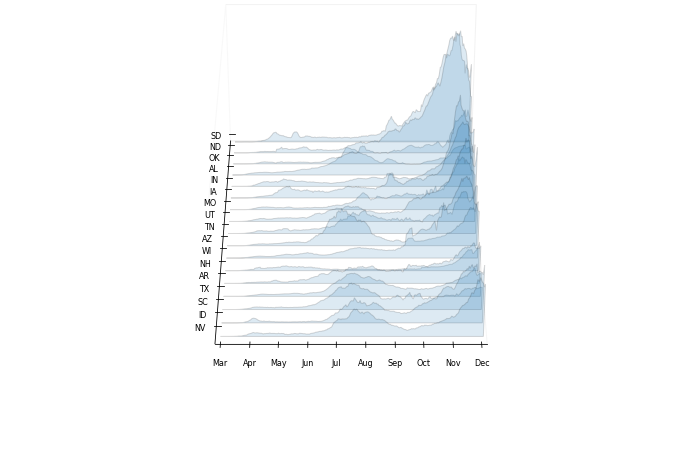

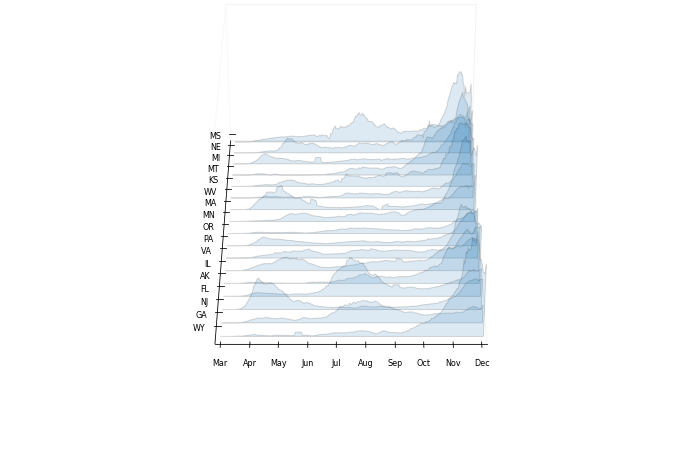

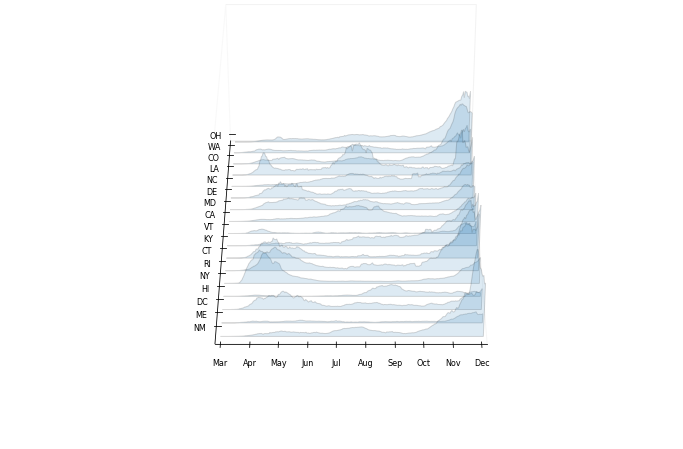

In [11]:
state_si = []
for i in range(len(state_code)):
    cc1 = state_code[i][0]
    tmp = calculate_average_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)
    state_si.append([cc1, tmp])

state_si.sort(key = lambda x: x[1], reverse=True)
# display(state_si)
si_thresholds = [0, 47, 51, 100]

for x in range(3):
    fig = plt.figure(figsize=(12, 8))
    ax0 = plt.figure().gca()
    ax = fig.gca(projection='3d')
    ax.elev = 35
    ax.azim = 270
    ax.dist = 14
    x_scale=1
    y_scale=2.1
    z_scale=1
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([x_scale, y_scale, z_scale, 1]))

    j = 0 
    state_list = []
    for i in range(len(state_code)):
        state = state_si[i][0]
        if state_si[i][1] < si_thresholds[x+1] and state_si[i][1] >= si_thresholds[x]:
            state_list.append(state[3:])
    for i in range(len(state_code)):
        state = state_si[i][0]
        if state_si[i][1] < si_thresholds[x+1] and state_si[i][1] >= si_thresholds[x]:
            plot_state_by_index(globals()["{0}_epi_df".format(state)], globals()["{0}_demo_df".format(state)], 
                                state, ax0, ax, j, state_list)
            j += 1
    plt.close()
    plt.savefig("fig_{0}".format(x), dpi=300)

PO
PO
[['IE' '81.48' '7.873653351851809']
 ['FR' '78.7' '39.98762020559113']
 ['AT' '75.0' '70.11933688026038']
 ['GB' '75.0' '31.36262785743171']
 ['CZ' '73.15' '47.06325806252565']
 ['ES' '71.3' '28.575653073651033']
 ['PH' '68.98' '1.368099488818492']
 ['IT' '66.67' '57.30872414826598']
 ['PT' '66.2' '62.324567927919695']
 ['IL' '65.74' '7.973414587577379']
 ['BE' '65.74' '33.0533131796872']
 ['NL' '65.74' '30.422779172458245']
 ['PO' '65.74' '30.422779172458245']
 ['CN' '63.43' '0.0018090751180114893']
 ['US' '62.5' '51.14509887081105']
 ['DE' '62.04' '22.20226161038513']
 ['IN' '61.57' '2.897231509060568']
 ['CA' '60.65' '12.60770391592912']
 ['TR' '60.65' '4.76179547555705']
 ['EG' '60.19' '0.2844674870603688']
 ['SE' '55.56' '43.87296724629823']
 ['SG' '52.78' '0.07263622379000137']
 ['IS' '52.78' '3.241378234025108']
 ['HK' '51.85' '0.13700767623563798']
 ['AU' '50.46' '0.0698394232268428']
 ['NO' '49.07' '10.987336303971603']
 ['CH' '49.07' '54.52780308544706']
 ['TH' '47.22' 

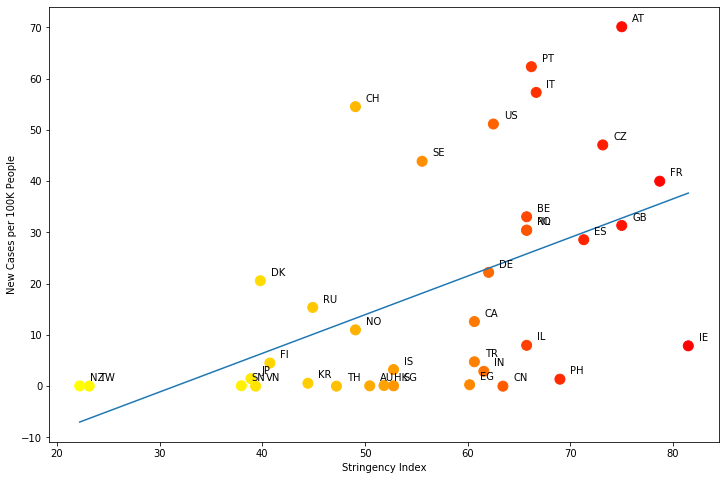

In [48]:
case_rate_v_stringency = []
date1 = '2020-11-5'
date2 = '2020-11-19'
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    try:
        date_si = globals()["{0}_gr_df".format(cc1)][pd.Timestamp(date1):pd.Timestamp(date1)]['stringency_index'].values[0]
    except:
        print(cc1)
    try:
        case_rate_100K = globals()["{0}_epi_df".format(cc1)]['rolling_cases']/globals()["{0}_demo_df".format(cc1)]['population'].values[0]*100000
    except:
        print(cc1)
    date_cr = case_rate_100K[pd.Timestamp(date2):pd.Timestamp(date2)].values[0]
    case_rate_v_stringency.append([cc1, date_si, date_cr])

case_rate_v_stringency.sort(key = lambda x: x[1], reverse=True)
case_rate_v_stringency = np.array(case_rate_v_stringency)
print(case_rate_v_stringency)
c = range(0, len(case_rate_v_stringency))
plt.figure(figsize=(12,8))
label = case_rate_v_stringency[:,0]
x = case_rate_v_stringency[:,1].astype(float)
y = case_rate_v_stringency[:,2].astype(float)
plt.scatter(x, y, s=100, c=c, cmap='autumn')
plt.xlabel('Stringency Index')
plt.ylabel('New Cases per 100K People')
b, m = polyfit(x, y, 1)
plt.plot(x, b + m * x, '-')
for i, txt in enumerate(label):
    plt.annotate(txt, (x[i]+1, y[i]+1))
plt.show()

## Case count vs stringency index

In [ ]:
for i in range(len(country_code)):
    cc1 = country_code[i][0]
    plot_stringency_index(globals()["{0}_epi_df".format(cc1)], globals()["{0}_gr_df".format(cc1)], 
                          globals()["{0}_demo_df".format(cc1)], cc1)

# Plot United States Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

In [ ]:
plot_health_policies(US_epi_df, US_gr_df, US_fc_df, US_demo_df, 'US')
plot_containment_policies(US_epi_df, US_gr_df, US_demo_df, 'US')

# Plot Australia Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

In [ ]:
plot_health_policies(AU_epi_df, AU_gr_df, AU_fc_df, AU_demo_df, 'Australia')
plot_containment_policies(AU_epi_df, AU_gr_df, AU_demo_df, 'Australia')

# Plot Senegal Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

In [ ]:
plot_health_policies(SN_epi_df, SN_gr_df, SN_fc_df, SN_demo_df, 'Senegal')
plot_containment_policies(SN_epi_df, SN_gr_df, SN_demo_df, 'Senegal')

# Plot Egypt Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

In [ ]:
plot_health_policies(EG_epi_df, EG_gr_df, EG_fc_df, EG_demo_df, 'Egypt')
plot_containment_policies(EG_epi_df, EG_gr_df, EG_demo_df, 'Egypt')

# Plot China Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

In [ ]:
plot_health_policies(CN_epi_df, CN_gr_df, CN_fc_df, CN_demo_df, 'China')
plot_containment_policies(CN_epi_df, CN_gr_df, CN_demo_df, 'China')